## [experiment] thailand 1x1 continuous

### MJJASO, JJA, JAS, ASO
- control (msot)
- soil moisture
- snow coverage
- sea surface temperature
- temperature of soil layer
- SST + MOISTURE
- SST + SNOW
- SST + SOIL TEMPERATURE

In [1]:
import numpy as np
import pickle
from scipy import stats
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [2]:
# thailand_1x1_continuous MJJASO

result_msot_MJJASO = f"/docker/mnt/d/research/D2/cnn3/result/continuous/thailand/1x1" \
                     f"/predictors_coarse_std_Apr_msot-pr_1x1_std_MJJASO_thailand" \
                     f"/epoch100_batch256_seed1.npy"
val_msot_MJJASO = f"/docker/mnt/d/research/D2/cnn3/train_val/continuous" \
                  f"/predictors_coarse_std_Apr_msot-pr_1x1_std_MJJASO_thailand.pickle"

result_m_MJJASO = f"/docker/mnt/d/research/D2/cnn3/result/continuous/thailand/1x1" \
                  f"/predictors_coarse_std_Apr_m-pr_1x1_std_MJJASO_thailand" \
                  f"/epoch100_batch256_seed1.npy"
val_m_MJJASO = f"/docker/mnt/d/research/D2/cnn3/train_val/continuous" \
                  f"/predictors_coarse_std_Apr_m-pr_1x1_std_MJJASO_thailand.pickle"

result_s_MJJASO = f"/docker/mnt/d/research/D2/cnn3/result/continuous/thailand/1x1" \
                  f"/predictors_coarse_std_Apr_s-pr_1x1_std_MJJASO_thailand" \
                  f"/epoch100_batch256_seed1.npy"
val_s_MJJASO = f"/docker/mnt/d/research/D2/cnn3/train_val/continuous" \
               f"/predictors_coarse_std_Apr_s-pr_1x1_std_MJJASO_thailand.pickle"

result_o_MJJASO = f"/docker/mnt/d/research/D2/cnn3/result/continuous/thailand/1x1" \
                  f"/predictors_coarse_std_Apr_o-pr_1x1_std_MJJASO_thailand" \
                  f"/epoch100_batch256_seed1.npy"
val_o_MJJASO = f"/docker/mnt/d/research/D2/cnn3/train_val/continuous" \
               f"/predictors_coarse_std_Apr_o-pr_1x1_std_MJJASO_thailand.pickle"

result_t_MJJASO =    f"/docker/mnt/d/research/D2/cnn3/result/continuous/thailand/1x1" \
                     f"/predictors_coarse_std_Apr_t-pr_1x1_std_MJJASO_thailand" \
                     f"/epoch100_batch256_seed1.npy"
val_t_MJJASO = f"/docker/mnt/d/research/D2/cnn3/train_val/continuous" \
               f"/predictors_coarse_std_Apr_t-pr_1x1_std_MJJASO_thailand.pickle"

result_mo_MJJASO =   f"/docker/mnt/d/research/D2/cnn3/result/continuous/thailand/1x1" \
              f"/predictors_coarse_std_Apr_mo-pr_1x1_std_MJJASO_thailand" \
              f"/epoch100_batch256_seed1.npy"
val_mo_MJJASO = f"/docker/mnt/d/research/D2/cnn3/train_val/continuous" \
                f"/predictors_coarse_std_Apr_mo-pr_1x1_std_MJJASO_thailand.pickle"

result_so_MJJASO =  f"/docker/mnt/d/research/D2/cnn3/result/continuous/thailand/1x1" \
                    f"/predictors_coarse_std_Apr_so-pr_1x1_std_MJJASO_thailand" \
                    f"/epoch100_batch256_seed1.npy"
val_so_MJJASO = f"/docker/mnt/d/research/D2/cnn3/train_val/continuous" \
                f"/predictors_coarse_std_Apr_so-pr_1x1_std_MJJASO_thailand.pickle"

result_ot_MJJASO = f"/docker/mnt/d/research/D2/cnn3/result/continuous/thailand/1x1" \
                   f"/predictors_coarse_std_Apr_ot-pr_1x1_std_MJJASO_thailand" \
                   f"/epoch100_batch256_seed1.npy"
val_ot_MJJASO = f"/docker/mnt/d/research/D2/cnn3/train_val/continuous" \
                f"/predictors_coarse_std_Apr_ot-pr_1x1_std_MJJASO_thailand.pickle" 

In [3]:
# loading validation input and predicted result
def load_pred(path, result_path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    x_val, y_val = data['x_val'], data['y_val']
    pred_arr = np.squeeze(np.load(result_path))
    return x_val, y_val, pred_arr

# ROC curve of AUC_mean of all experiments
def roc(sim, obs, percentile=20):
    sim = np.abs(sim)
    obs = np.abs(obs)
    
    sim_per =np.percentile(sim, percentile)
    obs_per = np.percentile(obs, percentile)
    
    over_per = sum(obs > obs_per)
    under_per = sum(obs <= obs_per)
    
    hit_count = 0
    false_count = 0
    for p in range(len(obs)):
        if sim[p] > sim_per and obs[p] > obs_per:
            hit_count += 1
        elif sim[p] > sim_per and obs[p] <= obs_per:
            false_count += 1
            
    hr = hit_count/over_per
    far = false_count/under_per
    
    return hr, far

def auc_sample_mean(sim, obs):
    """
    input: validation sample
        Calculation based on percentile of 1000 validation samples in each pixcel
        pred.T -> sim: (1000, 1728)
        y_val -> obs: (1000, 1728)
    output: AUC of pixcel map
    
    number of AUC -> pixcel map
    """
    # percentile variation list
    per_list = np.arange(10, 100, 10) # 10...90
    per_list = per_list[::-1]
    
    # result(11, 2, 1728) -> (percentile, hr or far, pixcel)
    result = []
    
    # initialize hr & far
    hr_all, far_all = [], []
    for i in range(len(obs.T)):
        hr_all.append(0)
        far_all.append(0)
    result.append([hr_all, far_all])
    
    # different percentile hr & far
    for per in per_list:
        # calculate multiple varidatoin events
        # len=1728
        hr_all, far_all = [], []
        # calculate roc
        for px in range(len(obs.T)):
            hr_n, far_n = roc(sim[:, px],
                              obs[:, px],
                              percentile=per)
            hr_all.append(hr_n)
            far_all.append(far_n)
        result.append([hr_all, far_all])
        
    # summerize hr & far
    hr_all, far_all = [], []
    for i in range(len(obs.T)):
        hr_all.append(1)
        far_all.append(1)
    result.append([hr_all, far_all])
    
    # result(11, 2, 1728)
    result = np.array(result)
    
    # calculate auc_all
    auc_all = []
    for px in range(len(obs.T)):
        fpr = result[:, 1, px]
        fpr = np.sort(fpr)
        tpr = result[:, 0, px]
        tpr = np.sort(tpr)
        AUC = auc(fpr, tpr)
        auc_all.append(AUC)
    auc_all = np.array(auc_all)
    
    # calculate 95% intervals
    n = len(auc_all)
    sample_mean = np.mean(auc_all)
    sample_var = stats.tvar(auc_all)
    interval = stats.norm.interval(alpha=0.95,
                                   loc=sample_mean,
                                   scale=np.sqrt(sample_var/n))
    print(f"auc_95%reliable_mean {sample_mean} spans {interval}")
    
    # hr_mean(11, far_mean(11)
    hr_mean = np.mean(result[:, 0, :], axis=1)
    far_mean = np.mean(result[:, 1, :], axis=1)
    result_mean = np.array([hr_mean, far_mean])
    result_mean = result_mean.T #(11, 2)
    
    # mean_auc
    fpr = result_mean[:, 1]
    tpr = result_mean[:, 0]
    mean_auc = auc(fpr, tpr)
    
    return result, result_mean, auc_all, mean_auc

In [10]:
def draw_roc_curve(roc_array, auc_array, name_list, color_list):
    plt.rcParams["font.size"] = 18
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # draw cnn_continuous line
    for i in range(len(name_list)):
        plt.plot(roc_array[i, :, 1], #fpr
                 roc_array[i, :, 0], # tpr
                 #label=f"{name_list[i]} (AUC = {np.round(auc_array[i], 2)})",
                 label='a',
                 color=color_list[i],
                 linestyle=":",
                 linewidth=4)

        # plot cnn_continuous percentile results
        plt.scatter(roc_array[i, :, 1], #fpr
                    roc_array[i, :, 0], # tpr
                    s=70,
                    color=color_list[i])
    
    plt.axis("square")
    plt.xlabel("FPR[False Positive Rate]")
    plt.ylabel("TPR[True Positive Rate]")
    #plt.title("cnn_continuous_pr_1x1")
    plt.legend()
    plt.show()

experiment result of Exmeriment 8
auc_95%reliable_mean 0.9474864543656432 spans (0.94638183204555, 0.9485910766857363)
experiment result of Exmeriment 1
auc_95%reliable_mean 0.9087593545502394 spans (0.9069239616455362, 0.9105947474549425)
experiment result of Experiment 2
auc_95%reliable_mean 0.8898276264021083 spans (0.8871175221875502, 0.8925377306166664)
experiment result of Experiment 3
auc_95%reliable_mean 0.872307299372288 spans (0.869922099642478, 0.874692499102098)
experiment result of Experiment 4
auc_95%reliable_mean 0.8266028605796312 spans (0.8249418761409316, 0.8282638450183307)


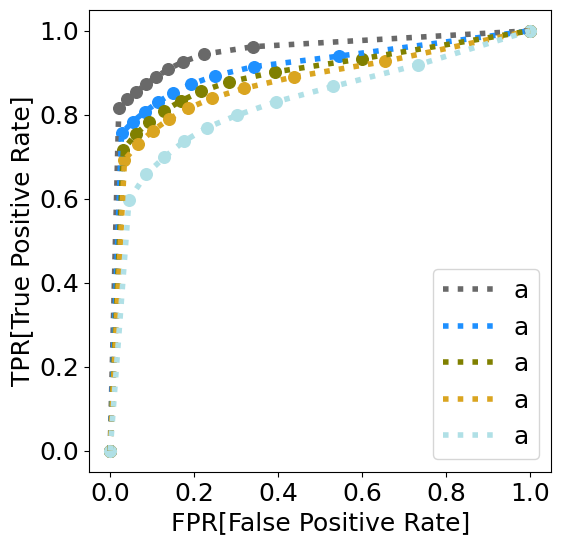

In [12]:
input_path_list = [val_msot_MJJASO,
                   val_o_MJJASO,
                   val_m_MJJASO,
                   val_t_MJJASO,
                   val_s_MJJASO,
                  ]
result_path_list = [result_msot_MJJASO,
                    result_o_MJJASO,
                    result_m_MJJASO,
                    result_t_MJJASO,
                    result_s_MJJASO,
                   ]
#name_list = ['msot', 'o', 'm', 't', 's']
name_list = ['Exmeriment 8', 'Exmeriment 1', 'Experiment 2', 'Experiment 3', 'Experiment 4']
#name_list = ['実験8', '実験2', '実験4', '実験1', '実験3']
color_list = ['dimgrey', 'dodgerblue', 'olive', 'goldenrod', 'powderblue']

# result_mean has (11, 2)shape
roc_list = []
auc_list = []
for inp, res, name in zip(input_path_list, result_path_list, name_list):
    print(f"experiment result of {name}")
    x_val, y_val, pred = load_pred(inp, res)
    result, result_mean, auc_all, mean_auc = auc_sample_mean(pred.T, y_val)
    roc_list.append(result_mean)
    auc_list.append(mean_auc)
roc_array = np.array(roc_list)
auc_array = np.array(auc_list)
    
# draw comparison graphs
draw_roc_curve(roc_array, auc_array, name_list, color_list)

experiment result of Exmeriment 8
auc_95%reliable_mean 0.9474864543656432 spans (0.94638183204555, 0.9485910766857363)
experiment result of control experiment
auc_95%reliable_mean 0.9087593545502394 spans (0.9069239616455362, 0.9105947474549425)


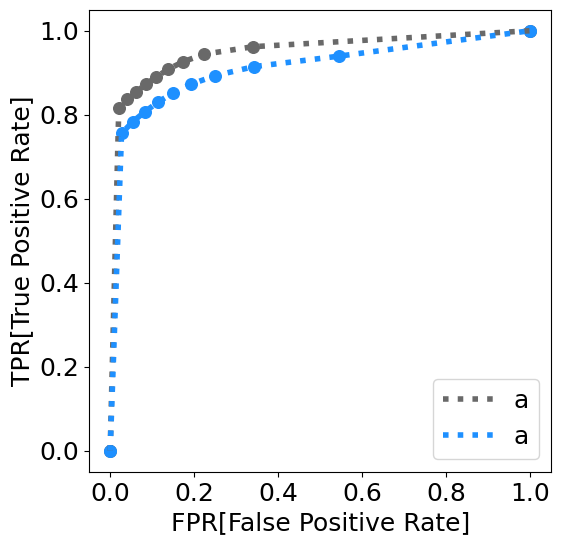

In [11]:
input_path_list = [val_msot_MJJASO,
                   val_o_MJJASO,
                  ]
result_path_list = [result_msot_MJJASO,
                    result_o_MJJASO,
                   ]
#name_list = ['msot', 'o', 'm', 't', 's']
name_list = ['Exmeriment 8', 'control experiment']
color_list = ['dimgrey', 'dodgerblue']

# result_mean has (11, 2)shape
roc_list = []
auc_list = []
for inp, res, name in zip(input_path_list, result_path_list, name_list):
    print(f"experiment result of {name}")
    x_val, y_val, pred = load_pred(inp, res)
    result, result_mean, auc_all, mean_auc = auc_sample_mean(pred.T, y_val)
    roc_list.append(result_mean)
    auc_list.append(mean_auc)
roc_array = np.array(roc_list)
auc_array = np.array(auc_list)
    
# draw comparison graphs
draw_roc_curve(roc_array, auc_array, name_list, color_list)